In [1]:
import numpy as np
import torch
import torchvision
import torchmetrics
import lightning.pytorch as pl 
from torchinfo import summary 
from torchview import draw_graph 
import matplotlib.pyplot as plt 
import pandas as pd

if (torch.cuda.is_available()): 
    device = ("cuda")
else:
    device = ("cpu")
print(f"Use GPU: {torch.cuda.is_available()}")

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


Use GPU: False


In [17]:
# Config Section

cfg_data_folder = "datasets/cifar10"
# cfg_log_folder = "logs"
# cfg_log_version = "cifar10"

cfg_max_epochs = 10
cfg_hidden_dim = 35
cfg_num_hidden_layers = 18

cfg_cifar10_labels = {
  0: "Airplane",
  1: "Automobile",
  2: "Bird",
  3: "Cat",
  4: "Deer",
  5: "Dog",
  6: "Frog",
  7: "Horse",
  8: "Ship",
  9: "Truck",
}

cfg_num_workers = 5


In [3]:
# Load the data set and scale to [-1,+1]
training_dataset = torchvision.datasets.CIFAR10(root=cfg_data_folder, download=True, train=True)
testing_dataset = torchvision.datasets.CIFAR10(root=cfg_data_folder,  download=True, train=False) 

x_train = (torch.Tensor(training_dataset.data) / 127.5) - 1.0
y_train = torch.Tensor(training_dataset.targets).to(torch.long)
x_test = (torch.Tensor(testing_dataset.data) / 127.5) - 1.0 
y_test = torch.Tensor(testing_dataset.targets).to(torch.long)

# You can set a seed value here if you
# want to control the shuffling process...
rng = np.random.default_rng()
permutation = rng.permutation(x_train.shape[0]) 
split_point = int(x_train.shape[0] * 0.8) # 80%/20% split

# Split into validation/training - keep test # set aside for later...
x_val = x_train[permutation][split_point:]
y_val = y_train[permutation][split_point:]
x_train = x_train[permutation][:split_point]
y_train = y_train[permutation][:split_point]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([40000, 32, 32, 3])
torch.Size([10000, 32, 32, 3])
torch.Size([10000, 32, 32, 3])


In [4]:
x_train.shape

torch.Size([40000, 32, 32, 3])

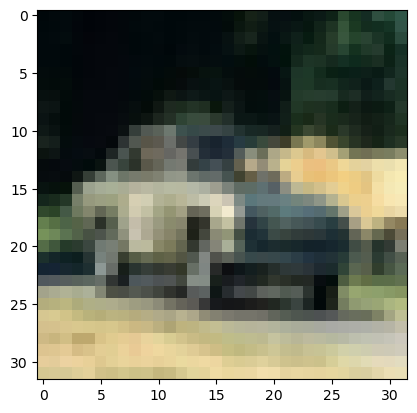

Label: Automobile (idx: 1)


In [5]:
plt.imshow((x_train[0].detach().numpy() + 1.0)/2.0)
plt.show()
print(f"Label: {cfg_cifar10_labels.get(int(y_train[0]))} (idx: {y_train[0]})")

In [6]:
# Define model
class DeepNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_hidden_layers, **kwargs):
        super().__init__(**kwargs) 
        self.flatten_layer = torch.nn.Flatten()
        
        # Initial linear projection
        layers = [torch.nn.Linear(input_size.numel(),
                                  hidden_size)]
        for _ in range(num_hidden_layers):
            layers = layers + [torch.nn.Linear(hidden_size, hidden_size), torch.nn.Tanh()]
            
        self.hidden_layers = torch.nn.Sequential(*layers)
        self.output_layer = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        y = x
        y = self.flatten_layer(y)
        y = self.hidden_layers(y)
        y = self.output_layer(y)
        return y
        
    def predict(self, x):
        y = x
        y = self.forward(y)
        y = torch.softmax(y,-1)
        return y



In [7]:
# Define Trainable Module
class PLModel(pl.LightningModule):
    def __init__(self, module, **kwargs):
        # This is the contructor, where we typically make
        # layer objects using provided arguments. 
        super().__init__(**kwargs) # Call the super class constructor 
        self.module = module
        
        # This creates an accuracy function
        self.model_acc = torchmetrics.classification.Accuracy(task='multiclass', 
                                                              num_classes=module.output_layer.out_features)
        # This creates a loss function
        self.model_loss = torch.nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.module.forward(x) 
        
    def predict(self, x):
        return self.module.predict(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx): 
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred, y_true)
        loss = self.model_loss(y_pred, y_true) 
        self.log('train_acc',  acc,  on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True) 
        return loss


    def validation_step(self, val_batch, batch_idx): 
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred, y_true)
        loss = self.model_loss(y_pred, y_true)
        self.log('val_acc',  acc,  on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred,y_true)
        loss = self.model_loss(y_pred,y_true)
        self.log('test_acc',  acc,  on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss


In [20]:
# Setup
model = PLModel(DeepNetwork(x_train.shape[1:],
                            len(y_train.unique()),
                            cfg_hidden_dim, # Using CFG
                            cfg_num_hidden_layers)) # Using CFG

summary(model, input_size=(1,)+x_train.shape[1:])

Layer (type:depth-idx)                   Output Shape              Param #
PLModel                                  [1, 10]                   --
├─DeepNetwork: 1-1                       --                        --
│    └─Flatten: 2-1                      [1, 3072]                 --
│    └─Sequential: 2-2                   [1, 35]                   --
│    │    └─Linear: 3-1                  [1, 35]                   107,555
│    │    └─Linear: 3-2                  [1, 35]                   1,260
│    │    └─Tanh: 3-3                    [1, 35]                   --
│    │    └─Linear: 3-4                  [1, 35]                   1,260
│    │    └─Tanh: 3-5                    [1, 35]                   --
│    │    └─Linear: 3-6                  [1, 35]                   1,260
│    │    └─Tanh: 3-7                    [1, 35]                   --
│    │    └─Linear: 3-8                  [1, 35]                   1,260
│    │    └─Tanh: 3-9                    [1, 35]                   -

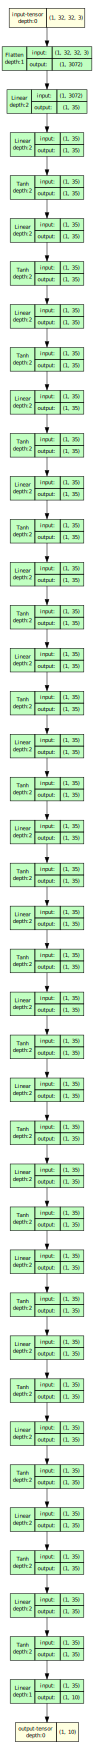

In [21]:
model_graph = draw_graph(model, input_size=(1,)+x_train.shape[1:], device=device, depth=3)
model_graph.visual_graph

In [22]:
predictions = model.predict(x_train[:5].to(device)).cpu().detach().numpy()

predictions

array([[0.09552129, 0.09048621, 0.11002263, 0.0878194 , 0.09322884,
        0.08905888, 0.11608551, 0.11365127, 0.09922526, 0.10490077],
       [0.09552108, 0.09048537, 0.11002294, 0.08781791, 0.09322835,
        0.08905815, 0.11608696, 0.11365146, 0.09922647, 0.10490137],
       [0.09552096, 0.09048527, 0.11002285, 0.08781881, 0.09322934,
        0.08905838, 0.11608567, 0.11365196, 0.09922628, 0.10490052],
       [0.09552048, 0.09048494, 0.1100232 , 0.0878174 , 0.09322855,
        0.08905786, 0.1160879 , 0.11365131, 0.09922722, 0.10490116],
       [0.09552038, 0.09048525, 0.11002321, 0.08781851, 0.09322941,
        0.08905816, 0.11608636, 0.11365165, 0.09922642, 0.10490064]],
      dtype=float32)

In [23]:
model.model_loss(model(x_train[:5].to(device)),
                 y_train[:5].to(device)
                ).cpu().detach().numpy()

array(2.3227985, dtype=float32)

In [24]:
model.model_acc(model(x_train[:5].to(device)),
                y_train[:5].to(device)).cpu().detach().numpy()

array(0.2, dtype=float32)

In [25]:
xy_train = torch.utils.data.DataLoader(list(zip(x_train, y_train)),
                                       shuffle=True,
                                       batch_size=250,
                                       num_workers=cfg_num_workers) # Using CFG

xy_val = torch.utils.data.DataLoader(list(zip(x_val, y_val)),
                                     shuffle=False,
                                     batch_size=250,
                                     num_workers=cfg_num_workers) # Using CFG

xy_test = torch.utils.data.DataLoader(list(zip(x_test, y_test)),
                                      shuffle=False,
                                      batch_size=250,
                                      num_workers=cfg_num_workers) # Using CFG

In [26]:
# Setup Logger
logger = pl.loggers.CSVLogger("logs", name="OL2", version="deep")

In [27]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=20)])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
# Validate on Model
trainer.validate(model, xy_val)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.10090000182390213    │
│         val_loss          │    2.3063621520996094     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.10090000182390213, 'val_loss': 2.3063621520996094}]

In [29]:
trainer.fit(model, xy_train, xy_val)


  | Name       | Type               | Params
--------------------------------------------------
0 | module     | DeepNetwork        | 130 K 
1 | model_acc  | MulticlassAccuracy | 0     
2 | model_loss | CrossEntropyLoss   | 0     
--------------------------------------------------
130 K     Trainable params
0         Non-trainable params
130 K     Total params
0.522     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [30]:
trainer.validate(model, xy_val)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.16949999332427979    │
│         val_loss          │    2.1512985229492188     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.16949999332427979, 'val_loss': 2.1512985229492188}]

In [31]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_acc,val_loss,epoch,step,train_acc,train_loss
0,0.1009,2.306362,0,0,NaN,NaN
1,0.1519,2.228097,0,159,NaN,NaN
2,NaN,NaN,0,159,0.148400,2.216922
3,0.1506,2.231628,1,319,NaN,NaN
4,NaN,NaN,1,319,0.150550,2.224098
5,0.1555,2.218390,2,479,NaN,NaN
6,NaN,NaN,2,479,0.153600,2.217590
7,0.1423,2.238114,3,639,NaN,NaN
8,NaN,NaN,3,639,0.162800,2.193602
9,0.1594,2.197534,4,799,NaN,NaN


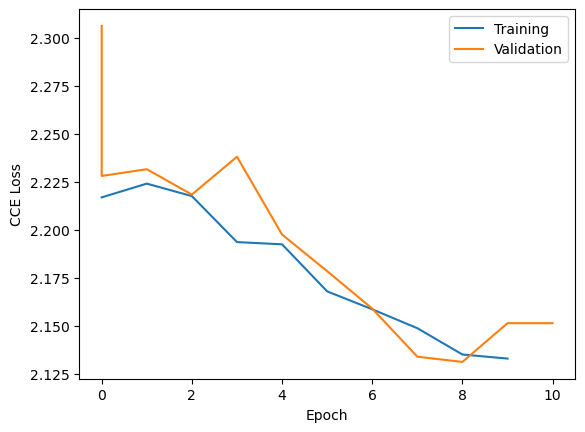

In [32]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")

plt.legend()
plt.ylabel("CCE Loss")
plt.xlabel("Epoch")
plt.show()

In [33]:
print("Validation accuracy:",*["%.8f"%(x) for x in results['val_acc'][np.logical_not(np.isnan(results["val_acc"]))]])

Validation accuracy: 0.10090000 0.15189999 0.15060000 0.15549999 0.14229999 0.15940000 0.14810000 0.16080000 0.16100000 0.18000001 0.16949999 0.16949999


In [34]:
print("Testing accuracy:", trainer.test(model, xy_test)[0]['test_acc'])

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.1655000001192093     │
│         test_loss         │    2.1478114128112793     │
└───────────────────────────┴───────────────────────────┘

Testing accuracy: 0.1655000001192093
